In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
iris = sns.load_dataset('iris')
# Display first few rows of the dataset
print(iris.head())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [3]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
# 기술통계량(종별 petal_length)
desc = iris.groupby("species")["petal_length"].describe()
count = iris["species"].value_counts()
desc, count


(            count   mean       std  min  25%   50%    75%  max
 species                                                       
 setosa       50.0  1.462  0.173664  1.0  1.4  1.50  1.575  1.9
 versicolor   50.0  4.260  0.469911  3.0  4.0  4.35  4.600  5.1
 virginica    50.0  5.552  0.551895  4.5  5.1  5.55  5.875  6.9,
 species
 setosa        50
 versicolor    50
 virginica     50
 Name: count, dtype: int64)

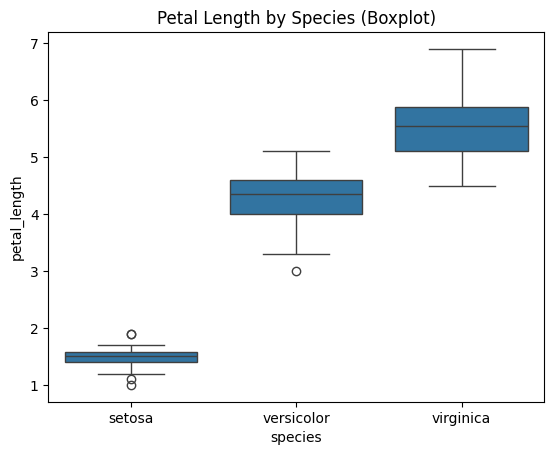

In [5]:
# 시각화
plt.figure()
sns.boxplot(data=iris, x="species", y="petal_length")
plt.title("Petal Length by Species (Boxplot)")
plt.show()


In [6]:
# 정규성 검정 (Shapiro-Wilk test)
alpha = 0.05
shapiro_results = []

for sp, grp in iris.groupby("species"):
    stat, p = stats.shapiro(grp["petal_length"])
    shapiro_results.append((sp, stat, p, "정규성 기각" if p < alpha else "정규성 기각 못함"))

shapiro_df = pd.DataFrame(shapiro_results, columns=["species", "W", "p_value", "decision@0.05"])
shapiro_df


,species,W,p_value,decision@0.05
0,setosa,0.954977,0.054811,정규성 기각 못함
1,versicolor,0.966004,0.158478,정규성 기각 못함
2,virginica,0.962186,0.109775,정규성 기각 못함


In [7]:
# 등분산성 검정
groups = [grp["petal_length"].values for _, grp in iris.groupby("species")]
stat, p = stats.levene(*groups, center="median")  # 보통 median 기반이 더 견고
stat, p, ("등분산성 기각" if p < alpha else "등분산성 기각 못함")


(np.float64(19.480338801923573), np.float64(3.1287566394085304e-08), '등분산성 기각')

𝐻0:𝜇_setosa=𝜇_versicolor=𝜇_virginica

H1: 적어도 한 종의 평균은 다르다

In [8]:
# scipy f_oneway
sp_names = iris["species"].unique()
data_by_sp = [iris.loc[iris["species"] == sp, "petal_length"].values for sp in sp_names]

F, p = stats.f_oneway(*data_by_sp)
F, p, ("귀무가설 기각" if p < alpha else "귀무가설 기각 못함")


(np.float64(1180.1611822529785), np.float64(2.856776610961989e-91), '귀무가설 기각')

In [9]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=iris["petal_length"],
                          groups=iris["species"],
                          alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor    2.798   0.0 2.5942 3.0018   True
    setosa  virginica     4.09   0.0 3.8862 4.2938   True
versicolor  virginica    1.292   0.0 1.0882 1.4958   True
---------------------------------------------------------


결과 요약은 보고서에 서술합니다.

In [10]:
X = iris[["sepal_length", "sepal_width", "petal_width"]]
y = iris["petal_length"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

coef = pd.Series(model.coef_, index=X.columns)
intercept = model.intercept_

mse, r2, intercept, coef


(0.13001626031382682,
 0.9603293155857664,
 np.float64(-0.2621959025887066),
 sepal_length    0.722815
 sepal_width    -0.635816
 petal_width     1.467524
 dtype: float64)